In [1]:
import jax.numpy as jnp
from jax import jit
from jax import grad
from jax import vmap
from jax import jacobian
from jax import jacfwd, jacrev
from jax import vjp
from jax.lax import scan
import matplotlib.pyplot as plt

## Development notebook 2

$\providecommand{\d}{\mathrm{d}}$

### Example problem 2
We now work on the 2 dimensional problem with $i\phi(x)=ix_1^2+ix_2^2$, where the analytic solution is available

$$
Z = \int_{-\infty}^\infty \d x e^{i\sum_i x_i^2} = [(1+i)\sqrt{\pi/2}]^2 = i\pi
$$

The idea of the Picard Lefschetz thimble approach is to analytically continue the integration domain from the real space $x$ to the complex space $z$ and to deform the integration path along which the integrand is a non-oscilating function.

$$
Z = \int_{\mathcal{J}} \d z e^{i \sum_i z_i^2}
$$

The flow equation to get Picard-Lefschetz (PL) thimble $\mathcal{J}$ is defined as

$$
\frac{\d z}{\d \sigma} = \overline{\frac{\partial\phi}{\partial z}}
$$

where $\overline{X}$ is the conjugate of value $X$, and $\sigma$ parametrize the flow of the path.

However the integral measure on the PL thimble is difficult to get. So, as discussed in Atis's paper, we instead use the following expression
$$
Z = \int_{-\infty}^\infty \d x \frac{\partial z}{\partial x} e^{i\phi}
$$
where $J=\frac{\partial z}{\partial x}$ is the Jacobian from $x$ to $z$. This expression is nice because the integral is performed on $x$ while the integrand is non-oscilating function, and also because the integral measure can be captured by keeping the evolution of the Jacobian along the flow, which can be easily done with the auto-differencial package like jax.

In [2]:
# actions
def action_iphi(z):
    iphi = 1j*z[0]**2 + 1j*z[1]**2
    return iphi

def action_h(z):
    ip= action_iphi(z)
    h = jnp.real(ip) + 0.0j
    return h

def action_Seff(z):
    seff = -action_iphi(z)
    return seff

def integrand(z):
    return jnp.exp(action_iphi(z))

# corresponding gradients
grad_iphi = grad(action_iphi, holomorphic=True)
grad_h    = grad(action_h, holomorphic=True)
grad_Seff = grad(action_Seff, holomorphic=True)

# integrand vmap
vintegrand = vmap(integrand)

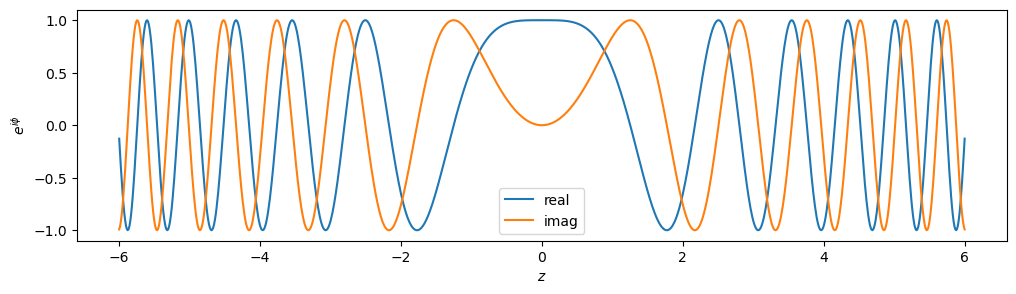

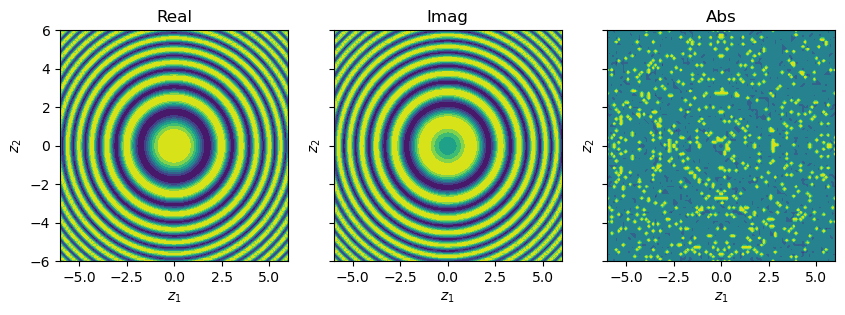

In [3]:
# integrand
z1 = jnp.linspace(-6, 6, 1000).astype(complex)
z2 = jnp.zeros_like(z1)
z = jnp.array([z1, z2])

i = integrand(z)
plt.figure(figsize=(12, 3))
plt.plot(z1.real, i.real, label='real')
plt.plot(z1.real, i.imag, label='imag')
plt.xlabel(r'$z$')
plt.ylabel(r'$e^{i\phi}$')
plt.legend()
plt.show()

# integrand (z1, z2)
x = jnp.linspace(-6, 6, 100)
shape = (x.size, x.size)
z1, z2 = jnp.meshgrid(x.astype(complex), x.astype(complex))
z = jnp.transpose(jnp.array([z1.ravel(), z2.ravel()]))

i = vintegrand(z)
i = jnp.reshape(i, shape)
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
axes[0].contourf(x, x, i.real, cmap='viridis')
axes[0].set_title('Real')
axes[0].set_xlabel(r'$z_1$')
axes[0].set_ylabel(r'$z_2$')
axes[1].contourf(x, x, i.imag, cmap='viridis')
axes[1].set_title('Imag')
axes[1].set_xlabel(r'$z_1$')
axes[1].set_ylabel(r'$z_2$')
axes[2].contourf(x, x, jnp.abs(i), cmap='viridis')
axes[2].set_title('Abs')
axes[2].set_xlabel(r'$z_1$')
axes[2].set_ylabel(r'$z_2$')
plt.show()

In [6]:
def flow_step(z, ds, thre=0.1):
    # dSdz = grad_Seff(z)
    # z = z - ds*dSdz
    dhdz = grad_h(z)
    z = z + ds*dhdz
    return z

def flow_n_steps(z, ds, n_step):
    fnc = lambda z, null: (flow_step(z, ds), null)
    z, null = scan(fnc, z, length=n_step)
    return z

def flow_n_steps_with_jac(z, ds, n_step):
    z = flow_n_steps(z, ds, n_step)
    j = jacrev(flow_n_steps, argnums=0, holomorphic=True)(z, ds, n_step)
    j = jnp.linalg.det(j)
    return z, j

vflow = vmap(flow_n_steps_with_jac, (0,None,None), 0)

CPU times: user 343 ms, sys: 19.4 ms, total: 362 ms
Wall time: 352 ms
CPU times: user 3.22 ms, sys: 142 µs, total: 3.36 ms
Wall time: 3.36 ms


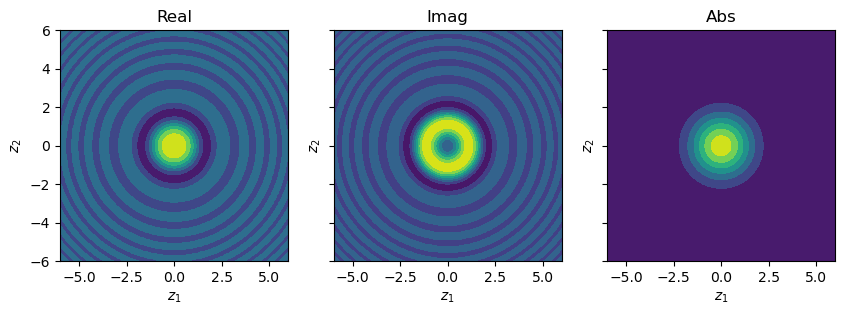

In [7]:
x = jnp.linspace(-6, 6, 100)
shape = (x.size, x.size)
z1, z2 = jnp.meshgrid(x.astype(complex), x.astype(complex))
z = jnp.transpose(jnp.array([z1.ravel(), z2.ravel()]))

%time z_pl,j = vflow(z, 1e-3, 100)
%time i = vintegrand(z_pl)
i = jnp.reshape(i, shape)

fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
axes[0].contourf(x, x, i.real, cmap='viridis')
axes[0].set_title('Real')
axes[0].set_xlabel(r'$z_1$')
axes[0].set_ylabel(r'$z_2$')
axes[1].contourf(x, x, i.imag, cmap='viridis')
axes[1].set_title('Imag')
axes[1].set_xlabel(r'$z_1$')
axes[1].set_ylabel(r'$z_2$')
axes[2].contourf(x, x, jnp.abs(i), cmap='viridis')
axes[2].set_title('Abs')
axes[2].set_xlabel(r'$z_1$')
axes[2].set_ylabel(r'$z_2$')
plt.show()

In [8]:
x = jnp.linspace(-6, 6, 100)
shape = (x.size, x.size)
z1, z2 = jnp.meshgrid(x.astype(complex), x.astype(complex))
z = jnp.transpose(jnp.array([z1.ravel(), z2.ravel()]))

z_pl,j = vflow(z, 1e-3, 100)
i = vintegrand(z_pl)

# integrate
dx = x[1] - x[0]
z_pl = jnp.sum(i*j*dx**2)

# analytic
z_ana= 1j*jnp.pi

print(f"PL : {z_pl} ")
print(f"Ana: {z_ana}")

PL : (2.384185791015625e-07+3.1415903568267822j) 
Ana: 3.141592653589793j
